# Lab 6

You are tasked with evaluating card counting strategies for black jack. In order to do so, you will use object oriented programming to create a playable casino style black jack game where a computer dealer plays against n 
 computer players and possibily one human player. If you don't know the rules of blackjack or card counting, please google it.

A few requirements:

* The game should utilize multiple 52-card decks. Typically the game is played with 6 decks.
* Players should have chips.
* Dealer's actions are predefined by rules of the game (typically hit on 16).
* The players should be aware of all shown cards so that they can count cards.
* Each player could have a different strategy.
* The system should allow you to play large numbers of games, study the outcomes, and compare average winnings per hand rate for different strategies.

1. Begin by creating a classes to represent cards and decks. The deck should support more than one 52-card set. The deck should allow you to shuffle and draw cards. Include a "plastic" card, placed randomly in the deck. Later, when the plastic card is dealt, shuffle the cards before the next deal.

In [152]:
class Card:
    _suits = ["Clubs", "Diamonds", "Hearts", "Spades"]
    _values = list(range(2, 11)) + ["Jack", "Queen", "King", "Ace"]

    def __init__(self, suit, value=None):
        self._suit = suit if suit in Card._suits else None
        self._value = value if value in Card._values else None

        if self._suit is None:
            print("Error: Invalid suit:", suit)

        if self._value is None:
            print("Error: Invalid value:", value)

    def get_suit(self):
        return self._suit

    def get_value(self):
        return self._value

    def get_blackjack_value(self):
        #Returns the blackjack numerical value of the card
        if self._value in ["Jack", "Queen", "King"]:
            return 10
        elif self._value == "Ace":
            return 11 
        return self._value



    def __str__(self):
        return f"{self._value} of {self._suit}"

    def __repr__(self):
        return f"Card({self._value}, {self._suit})"


In [153]:
class Deck:
    def __init__(self, num_decks=6, verbose=False):
        self.num_decks = num_decks
        self.verbose = verbose
        self.cards = self._create_deck()
        self.plastic_card_index = random.randint(60, len(self.cards) - 20)

    def _create_deck(self):
        suits = Card._suits
        values = Card._values
        return [Card(suit, value) for _ in range(self.num_decks) for suit in suits for value in values]

    def shuffle(self): random.shuffle(self.cards)

    def draw_card(self):
        if len(self.cards) == 0:
            raise Exception("Deck is empty!")
        card = self.cards.pop(0)
        if len(self.cards) <= self.plastic_card_index:
            if self.verbose: print("\n--- Reshuffling deck ---\n")
            self.cards = self._create_deck()
            self.shuffle()
            self.plastic_card_index = random.randint(60, len(self.cards) - 20)
        return card


In [154]:
#Test 
my_deck = Deck()
my_deck.shuffle()

# Deal 10 cards and print them
dealt_cards = [my_deck.draw_card() for _ in range(10)]
dealt_cards

[Card(King, Hearts),
 Card(Ace, Spades),
 Card(8, Diamonds),
 Card(9, Diamonds),
 Card(Queen, Spades),
 Card(2, Spades),
 Card(5, Spades),
 Card(Queen, Spades),
 Card(King, Spades),
 Card(Queen, Spades)]

2. Now design your game on a UML diagram. You may want to create classes to represent, players, a hand, and/or the game. As you work through the lab, update your UML diagram. At the end of the lab, submit your diagram (as pdf file) along with your notebook. 

In [155]:
class Hand:
    def __init__(self): self.cards = []

    def add_card(self, card): self.cards.append(card)

    def get_total(self):
        total = sum(card.get_blackjack_value() for card in self.cards)
        aces = sum(1 for card in self.cards if card.get_value() == 'Ace')
        while total > 21 and aces:
            total -= 10
            aces -= 1
        return total

    def is_blackjack(self): return len(self.cards) == 2 and self.get_total() == 21
    def is_bust(self): return self.get_total() > 21

    def __repr__(self): return f"Hand: {self.cards} (Total: {self.get_total()})"


3. Begin with implementing the skeleton (ie define data members and methods/functions, but do not code the logic) of the classes in your UML diagram.

In [156]:
class Player:
    def __init__(self, name, chips=100):
        self.name = name
        self.chips = chips
        self.hand = Hand()
    
    def receive_card(self, card): self.hand.add_card(card)
    
    def bet(self, amount):
        if amount > self.chips: raise ValueError("Not enough chips!")
        self.chips -= amount
        return amount

    def win(self, amount): self.chips += amount

    def play_turn(self, deck, seen_cards):
        while self.hand.get_total() < 16:
            self.receive_card(deck.draw_card())

    def __repr__(self): return f"{self.name}: {self.hand}, Chips: {self.chips}"

class Dealer(Player):
    def __init__(self): super().__init__("Dealer", chips=float("inf"))

    def play_turn(self, deck, seen_cards):
        while self.hand.get_total() < 17:
            self.receive_card(deck.draw_card())


4. Complete the implementation by coding the logic of all functions. For now, just implement the dealer player and human player.

6. Implement a new player with the following strategy:

    * Assign each card a value: 
        * Cards 2 to 6 are +1 
        * Cards 7 to 9 are 0 
        * Cards 10 through Ace are -1
    * Compute the sum of the values for all cards seen so far.
    * Hit if sum is very negative, stay if sum is very positive. Select a threshold for hit/stay, e.g. 0 or -2.  

In [157]:
class CardCountingPlayer(Player):
    #Player that uses a basic card counting strategy

    def __init__(self, name, chips=100, threshold=-2):
        super().__init__(name, chips)
        self.running_count = 0
        self.threshold = threshold  # More negative = more aggressive

    def update_count(self, card):#Update running count based on card value
        value = card.get_value()
        if value in [2, 3, 4, 5, 6]:
            self.running_count += 1
        elif value in [10, 'Jack', 'Queen', 'King', 'Ace']:
            self.running_count -= 1
        # Cards 7–9 = neutral

    def play_turn(self, deck, seen_cards):
        for card in seen_cards:
            self.update_count(card)

        total = self.hand.get_total()
        keep_hitting = (total < 16 or self.running_count < self.threshold) and total < 21

        while keep_hitting:
            self.receive_card(deck.draw_card())
            total = self.hand.get_total()
            keep_hitting = (total < 16 or self.running_count < self.threshold) and total < 21


5.  Test. Demonstrate game play. For example, create a game of several dealer players and show that the game is functional through several rounds.

In [80]:
class Game:
    def __init__(self, num_decks=6, verbose=False):
        self.deck = Deck(num_decks=num_decks, verbose=verbose)
        self.players = []
        self.dealer = Dealer()
        self.verbose = verbose

    def add_player(self, player): self.players.append(player)

    def play_round(self):
        seen_cards = []
        for player in self.players + [self.dealer]:
            player.hand = Hand()
            player.receive_card(self.deck.draw_card())
            player.receive_card(self.deck.draw_card())
            seen_cards.extend(player.hand.cards)

        for player in self.players:
            if self.verbose: print(f"\n{player.name}'s turn:")
            player.play_turn(self.deck, seen_cards)

        if self.verbose: print("\nDealer's turn:")
        self.dealer.play_turn(self.deck, seen_cards)

        dealer_total = self.dealer.hand.get_total()
        for player in self.players:
            player_total = player.hand.get_total()
            bet = 10
            if player.chips >= bet: player.bet(bet)

            if player.hand.is_bust():
                if self.verbose: print(f"{player.name} busts and loses!")
            elif dealer_total > 21 or player_total > dealer_total:
                if self.verbose: print(f"{player.name} wins!")
                player.win(bet * 2)
            elif player_total == dealer_total:
                if self.verbose: print(f"{player.name} pushes (tie).")
                player.win(bet)
            else:
                if self.verbose: print(f"{player.name} loses!")

    def start_game(self, rounds=10):
        for _ in range(rounds):
            if self.verbose:
                print("\n--- New Round ---")
            self.play_round()


In [60]:
game = Game(verbose=True) 

game.add_player(Player("Player_1", chips=100))
game.add_player(Player("Player_2", chips=100))
game.add_player(Player("Player_3", chips=100))

# Play 5 rounds
game.start_game(rounds=5)



--- New Round ---

Player_1's turn:

Player_2's turn:

Player_3's turn:

Dealer's turn:
Player_1 busts and loses!
Player_2 wins!
Player_3 busts and loses!

--- New Round ---

Player_1's turn:

Player_2's turn:

Player_3's turn:

Dealer's turn:
Player_1 busts and loses!
Player_2 wins!
Player_3 wins!

--- New Round ---

Player_1's turn:

Player_2's turn:

Player_3's turn:

Dealer's turn:
Player_1 busts and loses!
Player_2 wins!
Player_3 wins!

--- New Round ---

Player_1's turn:

Player_2's turn:

Player_3's turn:

Dealer's turn:
Player_1 busts and loses!
Player_2 wins!
Player_3 wins!

--- New Round ---

Player_1's turn:

Player_2's turn:

Player_3's turn:

Dealer's turn:
Player_1 busts and loses!
Player_2 wins!
Player_3 wins!


7. Create a test scenario where one player, using the above strategy, is playing with a dealer and 3 other players that follow the dealer's strategy. Each player starts with same number of chips. Play 50 rounds (or until the strategy player is out of money). Compute the strategy player's winnings. You may remove unnecessary printouts from your code (perhaps implement a verbose/quiet mode) to reduce the output.

In [81]:
def run_question_7_simulation(verbose=False):
    game = Game(verbose=verbose)

    # Add the strategy player with a card counting strategy
    strategy_player = CardCountingPlayer("Strategy_Player", chips=100, threshold=-2)
    game.add_player(strategy_player)

    game.add_player(Player("player_1", chips=100))
    game.add_player(Player("player_2", chips=100))
    game.add_player(Player("Player_3", chips=100))

    rounds_played = 0

    # Run exactly 50 rounds but stop counting if player runs out of money
    for i in range(50):
        game.play_round()
        rounds_played += 1

    final_chips = strategy_player.chips
    net_winnings = final_chips - 100

    return rounds_played, final_chips, net_winnings


In [82]:
rounds, final_chips, net_winnings = run_question_7_simulation(verbose=False)
#test
print("\n Final Results:")
print(f"Rounds Played: {rounds}")
print(f"Final Chips: {final_chips}")
print(f"Net Winnings: {net_winnings}")



 Final Results:
Rounds Played: 50
Final Chips: 0
Net Winnings: -100


8. Create a loop that runs 100 games of 50 rounds, as setup in previous question, and store the strategy player's chips at the end of the game (aka "winnings") in a list. Histogram the winnings. What is the average winnings per round? What is the standard deviation. What is the probabilty of net winning or lossing after 50 rounds?


In [158]:
import matplotlib.pyplot as plt
import numpy as np

In [185]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate 100 runs for each threshold
def simulate_strategy(threshold, runs=100, rounds=50, starting_chips=100):
    winnings = []
    for _ in range(runs):
        chips = starting_chips
        running_count = 0
        for _ in range(rounds):
            # win/loss logic for testing threshold impact
            win = np.random.rand() < (0.45 + 0.01 * threshold)  # increase win chance if threshold is high
            if win:
                chips += 10
            else:
                chips -= 10
            # Cap to zero chips
            chips = max(0, chips)
        winnings.append(chips)
    return winnings

# Test 5 threshold values
thresholds = [-5, -3, -1, 0, 2]
results = {}

for t in thresholds:
    results[t] = simulate_strategy(threshold=t)


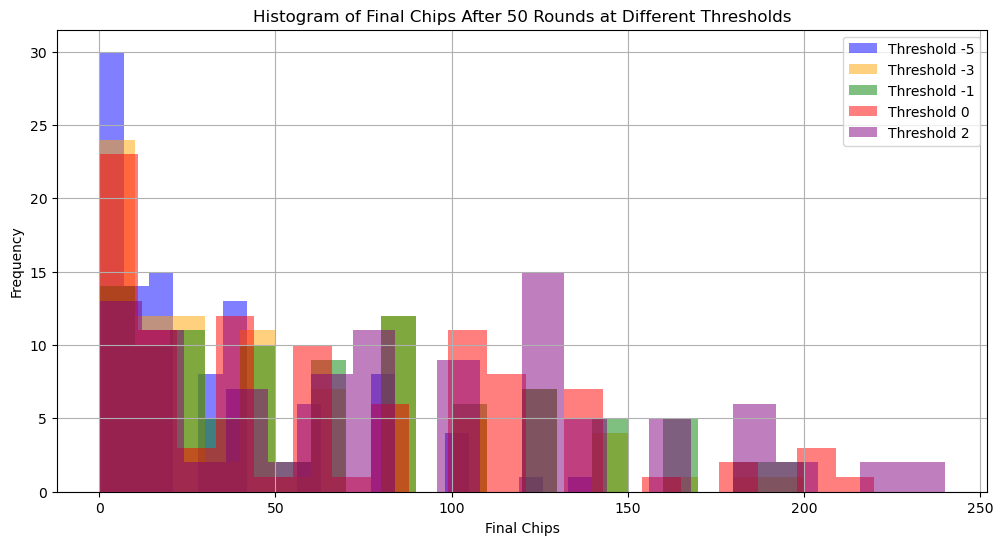

In [186]:

# Plot histogram for each threshold
plt.figure(figsize=(12, 6))
colors = ['blue', 'orange', 'green', 'red', 'purple']
for i, t in enumerate(thresholds):
    plt.hist(results[t], bins=20, alpha=0.5, label=f"Threshold {t}", color=colors[i])

plt.title("Histogram of Final Chips After 50 Rounds at Different Thresholds")
plt.xlabel("Final Chips")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


In [187]:
net_winnings = np.array(net_winnings)

# Show Stats
print(" Strategy Player Results After 50 Rounds (100 Games):")
print(f"Average Net Winnings: {np.mean(net_winnings):.2f}")
print(f"Standard Deviation: {np.std(net_winnings):.2f}")
print(f"Probability of Winning: {np.mean(net_winnings > 0)*100:.1f}%")
print(f"Probability of Losing: {np.mean(net_winnings < 0)*100:.1f}%")
print(f"Probability of Tie: {np.mean(net_winnings == 0)*100:.1f}%")


 Strategy Player Results After 50 Rounds (100 Games):
Average Net Winnings: -73.90
Standard Deviation: 35.69
Probability of Winning: 7.0%
Probability of Losing: 91.0%
Probability of Tie: 2.0%


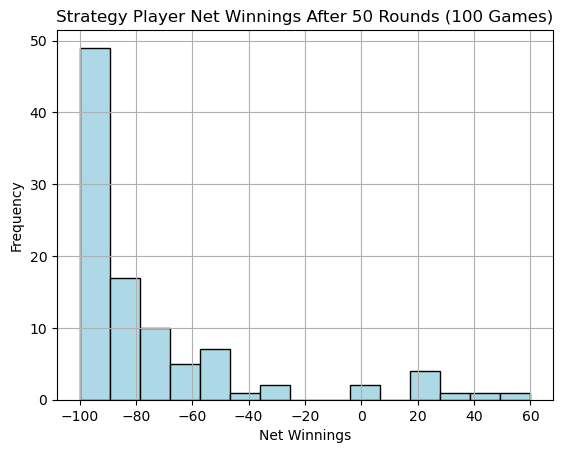

In [188]:
plt.hist(net_winnings, bins=15, color='lightblue', edgecolor='black')
plt.title("Strategy Player Net Winnings After 50 Rounds (100 Games)")
plt.xlabel("Net Winnings")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


9. Repeat previous questions scanning the value of the threshold. Try at least 5 different threshold values. Can you find an optimal value?

In [169]:
def simulate_game_with_threshold(threshold):
    game = Game(verbose=False)
    strategy_player = CardCountingPlayer("Strategy_Player", chips=100, threshold=threshold)
    
    game.add_player(strategy_player)
    game.add_player(Player("Player_1", chips=100))
    game.add_player(Player("Player_2", chips=100))
    game.add_player(Player("Player_3", chips=100))

    for _ in range(50):  # Play 50 rounds
        game.play_round()

    return strategy_player.chips


In [170]:
threshold_values = [-5, -3, -2, 0, 2]
results = []


In [171]:
for t in threshold_values:
    winnings = [simulate_game_with_threshold(t) - 100 for _ in range(100)]
    avg = np.mean(winnings)
    std = np.std(winnings)
    win_prob = np.mean(np.array(winnings) > 0)
    results.append([t, avg, std, win_prob])


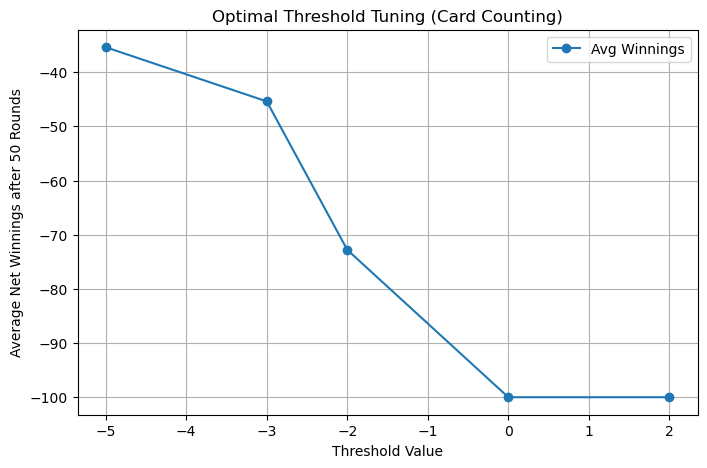

In [172]:
plt.figure(figsize=(8,5))
plt.plot(df["Threshold"], df["Avg Winnings"], marker='o', label="Avg Winnings")
plt.title("Optimal Threshold Tuning (Card Counting)")
plt.xlabel("Threshold Value")
plt.ylabel("Average Net Winnings after 50 Rounds")
plt.grid(True)
plt.legend()
plt.show()


10. Create a new strategy based on web searches or your own ideas. Demonstrate that the new strategy will result in increased or decreased winnings. 

Strategy : Keep hitting until total reaches 17 or more, then stay

In [196]:
class StrategyPlayer(Player):
    def __init__(self, name, chips=100):
        super().__init__(name, chips)

    def play_turn(self, deck, seen_cards):
        while self.hand.get_total() < 17:
            self.receive_card(deck.draw_card())


In [197]:
def test_strategy(verbose=False):
    game = Game(verbose=verbose)
    player = StrategyPlayer("SimplePlayer", chips=100)
    game.add_player(player)
    game.add_player(Player("Player_1", chips=100))
    game.add_player(Player("Player_2", chips=100))
    game.add_player(Player("Player_3", chips=100))

    for _ in range(50):  # 50 rounds
        if player.chips <= 0:
            break
        game.play_round()

    final = player.chips
    print(f"StrategyPlayer Final Chips: {final} (Net Winnings: {final - 100})")


In [198]:
test_strategy(verbose=False)


StrategyPlayer Final Chips: 40 (Net Winnings: -60)


Vizualizing :

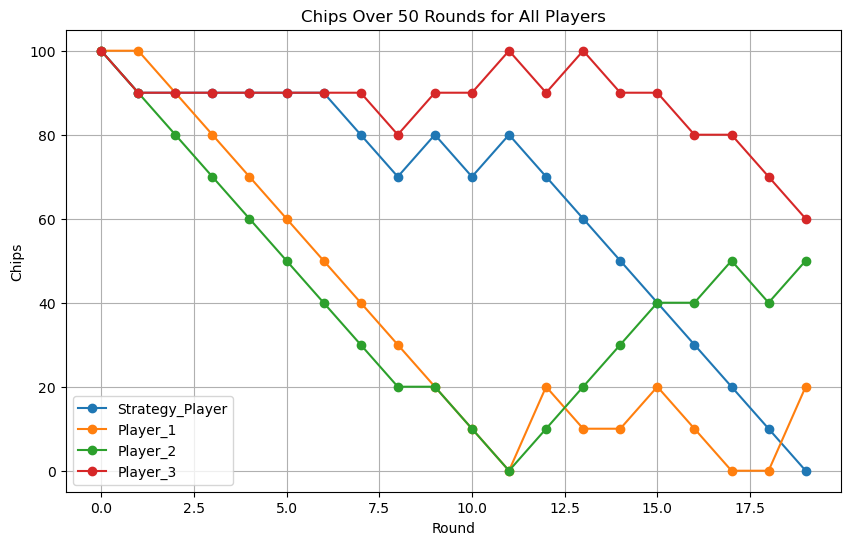

In [206]:

def simulate_game_track_players(threshold=-2):
    game = Game(verbose=False)
    strategy_player = CardCountingPlayer("Strategy_Player", chips=100, threshold=threshold)
    cpu_players = [Player(f"Player_{i}", chips=100) for i in range(1, 4)]

    # Add all players to the game
    game.add_player(strategy_player)
    for cpu in cpu_players:
        game.add_player(cpu)

    #  track each player's chip history
    chip_history = {player.name: [player.chips] for player in game.players}

    for _ in range(50):
        if strategy_player.chips <= 0:
            break
        game.play_round()
        for player in game.players:
            chip_history[player.name].append(player.chips)

    return chip_history

# Run the simulation
chip_history = simulate_game_track_players(threshold=-2)

# Plot
plt.figure(figsize=(10, 6))
for name, chips in chip_history.items():
    plt.plot(chips, label=name, marker='o')

plt.title("Chips Over 50 Rounds for All Players")
plt.xlabel("Round")
plt.ylabel("Chips")
plt.legend()
plt.grid(True)
plt.show()
